In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import py7zr

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, LSTM, SimpleRNN, Conv1D, MaxPooling1D

In [3]:
# om alle audio van 7z uit te pakken (eenmalig nodig)

# with py7zr.SevenZipFile("./tensorflow-speech-recognition-challenge/train.7z", "r") as archive:
#     archive.extractall("./tensorflow-speech-recognition-challenge/")

# with py7zr.SevenZipFile("./tensorflow-speech-recognition-challenge/test.7z", "r") as archive:
#     archive.extractall("./tensorflow-speech-recognition-challenge/")

In [4]:
data_dir = './tensorflow-speech-recognition-challenge/'

train_dir = os.path.join(data_dir, 'train/audio/')
test_dir = os.path.join(data_dir, 'test/audio')

# Visualiseer de data

Laten we eerst eens naar een enkel bestand kijken waarin het woord 'cat' wordt uitgesproken.

In [5]:
# het pad ophalen
example_filename = os.path.join(train_dir, 'cat/00b01445_nohash_0.wav')

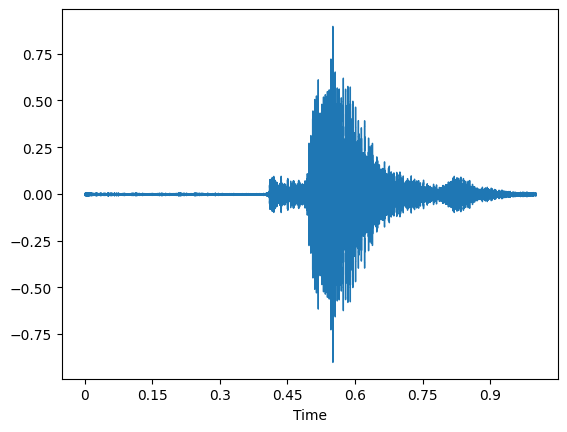

In [6]:
samples_cat, sample_rate = librosa.load(example_filename)

librosa.display.waveshow(samples_cat, sr = sample_rate)

In [7]:
len(samples_cat)

22050

Ter vergelijking bekijken we een opname van het woord 'dog'.

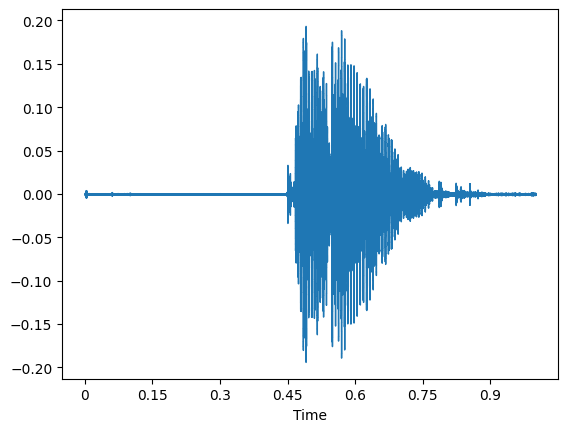

In [8]:
example_filename = os.path.join(train_dir, 'dog/0a7c2a8d_nohash_0.wav')

samples_dog, sample_rate = librosa.load(example_filename)

librosa.display.waveshow(samples_dog, sr = sample_rate)

In [9]:
len(samples_dog)

22050

## Spectrum

We plotten de frequenties in een klein stuk van de opname van 'cat'.

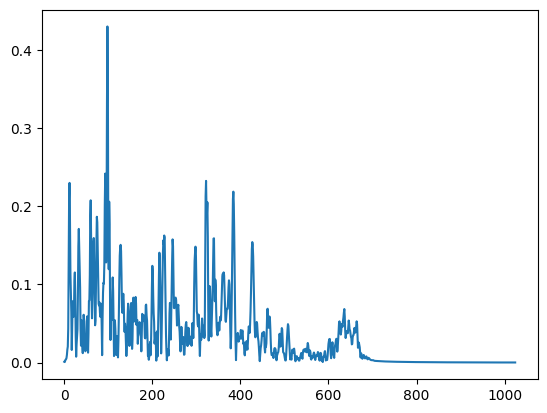

In [10]:
n_fft = 2048
plt.plot(np.abs(librosa.stft(samples_cat[:n_fft], n_fft=n_fft, hop_length = n_fft + 1)))

## Spectogram

Een spectogram laat de geluidsintensiteit op verschillende frequenties uitgezet in de tijd zien.

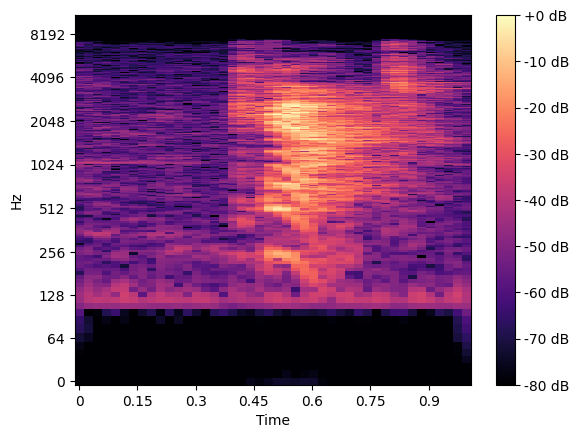

In [11]:
#cat

hop_length = 512

stft = np.abs(librosa.stft(samples_cat, n_fft = n_fft, hop_length = hop_length))
DB = librosa.amplitude_to_db(stft, ref=np.max)

librosa.display.specshow(DB, sr = sample_rate, x_axis = 'time', y_axis = 'log');
plt.colorbar(format='%+2.0f dB')

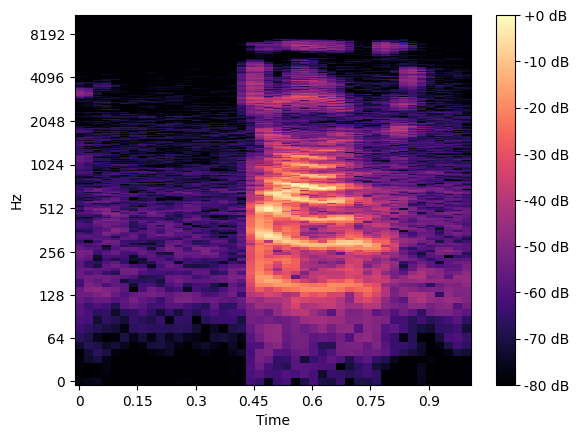

In [12]:
#dog

stft = np.abs(librosa.stft(samples_dog, n_fft = n_fft, hop_length = hop_length))
DB = librosa.amplitude_to_db(stft, ref=np.max)

librosa.display.specshow(DB, sr = sample_rate, x_axis = 'time', y_axis = 'log');
plt.colorbar(format='%+2.0f dB')

## MFCC

MFCC features proberen de belangrijkste informatie in een spraaksignaal te representeren.

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\523003715.py:1: FutureWarning: Pass y=[ 0.00159739  0.00268887 -0.00178751 ... -0.00644882  0.00080043
  0.00332253] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples_cat, sr = sample_rate, n_mfcc = 13)


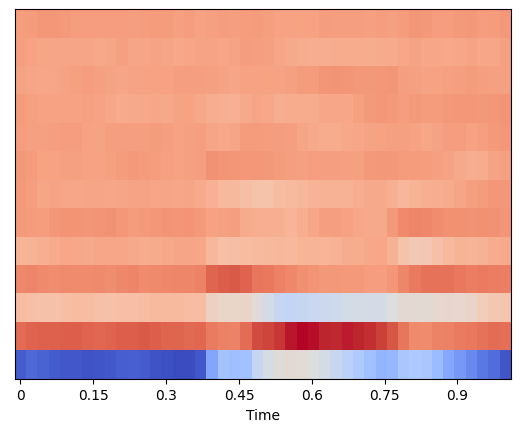

In [13]:
mfccs = librosa.feature.mfcc(samples_cat, sr = sample_rate, n_mfcc = 13)
librosa.display.specshow(mfccs, x_axis='time')

# Herkennen van woorden

We kunnen de MFCC representatie gebruiken als input voor een deep learning model. We gaan proberen om een aantal verschillend woorden te herkennen met behulp van een LSTM. 

Je kunt eventueel meer labels toevoegen (namen van de mappen in de dataset).

In [14]:
labels = ['cat', 'dog', 'yes', 'no']

## Prepareer de data

We zetten alle opnamen van de betreffende woorden om in MFCC features. We kiezen hier voor 13 MFCC features die we elke 10 ms berekenen voor een stukje van 25 ms van het spraaksignaal.

In [15]:
X_train = []
y_train = []

max_len = 80 # om ons model iets te vereenvoudingen gebruiken we een vaste lengte voor de inputs


for label in labels:
    wav_dir = os.path.join(train_dir, label)
    waves = [f for f in os.listdir(wav_dir) if f.endswith('.wav')]
    
    for wav in waves:
        samples, sample_rate = librosa.load(os.path.join(wav_dir, wav), sr = 16000)
        mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
        
        if (mfccs.shape[1] > max_len): # sla opnamen die te kort zijn over
            mfccs = mfccs[:, :max_len]
        
            X_train.append(mfccs)
            y_train.append(label)

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00314331 -0.00311279 -0.00100708 ... -0.0022583  -0.00411987
 -0.00500488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00234985 -0.00384521 -0.00274658 ... -0.00335693 -0.00143433
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00125122  0.00180054 -0.00509644 ... -0.0085144  -0.00509644
  0.00363159] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00125122 -0.00683594 -0.00698853 ...  0.0015564   0.00259399
  0.00369263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00234985 -0.00231934 -0.00244141 ... -0.00271606 -0.00280762
 -0.00299072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.04031372 0.04101562 0.04110718 ... 0.04159546 0.0411377  0.04049683] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.01425171 0.01394653 0.01397705 ... 0.01950073 0.01959229 0.01916504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.2207031e-04 -1.2207031e-04  3.0517578e-05 ... -3.0517578e-04
 -5.1879883e-04  6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 3.0517578e-05 0.0000000e+00 ... 0.0000000e+00 3.0517578e-05
 6.1035156e-05] as keyword args. 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00106812 -0.00088501 -0.0012207  ...  0.0015564   0.0012207
  0.00125122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00042725  0.00091553  0.00106812 ... -0.00314331 -0.00317383
 -0.00247192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00024414  0.0010376  -0.0010376  ... -0.0010376  -0.00091553
 -0.00097656] as keyword args. From version 0.10 passin

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01498413 -0.02297974 -0.01663208 ... -0.01208496 -0.01184082
 -0.00613403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.02127075  0.03613281  0.03155518 ... -0.12789917 -0.07830811
 -0.00878906] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  6.1035156e-05  1.2207031e-04 ... -9.1552734e-05
 -1.5258789e-04 -3.0517578e-04] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -1.2207031e-04 -4.5776367e-04 ... -3.6621094e-04
 -2.4414062e-04 -1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[6.1035156e-05 3.9672852e-04 6.1035156e-04 ... 4.2724609e-04 3.6621094e-04
 3.3569336e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00021362 -0.00012207 ...  0.00021362 -0.00033569
 -0.0007019 ] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00067139 -0.00079346 -0.00094604 ... -0.00057983 -0.00073242
 -0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00064087 -0.0005188  -0.00076294 ... -0.00064087 -0.00045776
 -0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00195312 -0.00210571 -0.00158691 ... -0.00149536 -0.00167847
 -0.00149536] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00198364  0.00177002  0.00195312 ... -0.00030518  0.00119019
  0.00314331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00045776 -0.00036621 -0.00030518 ...  0.00042725  0.00039673
  0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 4.5776367e-04  1.3122559e-03  9.1552734e-04 ... -6.1035156e-05
  3.6926270e-03  3.5095215e-03] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00552368 -0.0057373  -0.00527954 ... -0.00698853 -0.006073
 -0.00637817] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00216675 -0.00430298 -0.00662231 ... -0.00436401 -0.00384521
 -0.00405884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.01074219 0.01187134 0.01150513 ... 0.00860596 0.00970459 0.0123291 ] as keyword args. From version 0.10 passing these 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00341797  0.00494385  0.00357056 ... -0.00180054 -0.00289917
 -0.00402832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05  3.0517578e-05 ...  1.8310547e-04
  2.4414062e-04  2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00076294 -0.00125122 -0.0010376  ... -0.00045776 -0.00012207
  0.        ] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00048828 -0.00039673 -0.00079346 ...  0.00195312  0.00189209
  0.00219727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  0.0000000e+00 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00027466  0.0012207   0.00149536 ... -0.00045776 -0.00097656
 -0.00112915] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01101685 -0.02178955 -0.01940918 ...  0.03405762  0.03646851
  0.02716064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414  0.00036621  0.00045776 ... -0.0007019  -0.00085449
 -0.00085449] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  3.0517578e-05  1.2207031e-04 ... -5.7983398e-04
 -3.0517578e-04 -1.8310547e-04] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00228882  0.00543213  0.00814819 ... -0.00683594 -0.00595093
 -0.00473022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0007019  0.00054932 0.00057983 ... 0.00256348 0.00222778 0.00210571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[5.7983398e-04 6.1035156e-04 6.1035156e-05 ... 6.8664551e-03 4.3334961e-03
 3.6010742e-03] as keyword args. From version 0.10 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00033569 -0.00170898 -0.00192261 ...  0.00192261  0.00244141
  0.00228882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  0.0000000e+00  9.1552734e-05 ...  1.5258789e-04
  1.2207031e-04 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -6.1035156e-05 -3.0517578e-05 ... -2.7465820e-04
 -9.1552734e-05  9.1552734e-05] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00842285 -0.01361084 -0.01507568 ... -0.01928711 -0.01776123
 -0.01208496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00366211  0.01037598  0.00759888 ... -0.00939941 -0.00857544
 -0.00842285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.00732422 -0.00408936 ... -0.0017395  -0.00146484
 -0.00054932] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00061035  0.00152588  0.00384521 ...  0.00378418  0.00323486
 -0.0005188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00076294 0.00128174 0.00125122 ... 0.0007019  0.00085449 0.00128174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.1035156e-05
 -3.0517578e-05  0.0000000e+00] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0010376   0.00119019 -0.00338745 ...  0.00042725  0.00027466
  0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-2.0751953e-03 -2.4108887e-03 -6.1035156e-05 ... -1.1291504e-03
 -1.8615723e-03  1.0070801e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-04 -6.1035156e-05 -1.8615723e-03 ...  7.3242188e-04
 -2.7465820e-04  1.0681152e-03] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00350952 -0.00701904 -0.01037598 ... -0.0144043  -0.01239014
 -0.01074219] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00100708 -0.00708008 -0.00540161 ... -0.01583862 -0.01254272
 -0.00198364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00366211  0.00054932 ... -0.00067139  0.00112915
 -0.00177002] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00018311 -0.00030518 -0.00015259 ...  0.00036621  0.00027466
  0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01028442 -0.01177979 -0.00650024 ... -0.00201416 -0.00323486
 -0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00372314 -0.00088501  0.0010376  ... -0.00253296 -0.00231934
 -0.00234985] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 1.0986328e-03  1.4343262e-03  1.3427734e-03 ... -5.4931641e-04
  3.0517578e-05  2.1362305e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 7.6293945e-04  7.6293945e-04  1.2817383e-03 ... -3.0517578e-05
 -2.4414062e-04 -2.1362305e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0067749  0.01126099 0.01626587 ... 0.01416016 0.01559448 0.01095581] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00234985 -0.00479126 -0.00656128 ...  0.00436401  0.00457764
  0.00494385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -9.1552734e-05 ...  9.1552734e-05
  1.5258789e-04  9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05  1.5258789e-04  3.0517578e-05 ...  2.7465820e-04
  6.1035156e-05 -1.2207031e-04] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00247192 0.00408936 0.00521851 ... 0.00411987 0.00378418 0.00363159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00033569  0.0005188   0.00082397 ... -0.00067139 -0.00054932
 -0.00106812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0015564  -0.00418091 -0.00460815 ... -0.00418091 -0.003479
 -0.00292969] as keyword args. From version 0.10 passing these 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05  0.0000000e+00 ...  3.0517578e-05
  3.0517578e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00054932 -0.0007019  -0.00064087 ...  0.00064087  0.00073242
  0.00076294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0015564  -0.00198364 -0.00213623 ... -0.00238037 -0.00231934
 -0.0020752 ] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.02212524 0.02346802 0.02270508 ... 0.02325439 0.02307129 0.021698  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-8.5449219e-04 -1.6479492e-03 -1.6174316e-03 ...  9.1552734e-05
  2.4414062e-04  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -1.5258789e-04 -9.1552734e-05 ...  1.5258789e-04
  2.1362305e-04  3.3569336e-04] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00265503 -0.00689697 -0.01144409 ...  0.00527954  0.00463867
  0.00683594] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00360107 -0.00796509 -0.00808716 ...  0.01074219  0.00878906
  0.0071106 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00039673  0.00042725  0.00042725 ... -0.00100708 -0.00097656
 -0.00085449] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00100708  0.0005188   0.00128174 ...  0.00247192 -0.00180054
 -0.00076294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00021362 0.0012207  0.00085449 ... 0.00140381 0.00140381 0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00164795 -0.0043335  -0.0017395  ... -0.00292969 -0.00335693
 -0.00296021] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  9.1552734e-05  1.8310547e-04 ... -6.4086914e-04
 -5.4931641e-04  6.1035156e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.5258789e-04 -5.1879883e-04 -1.5258789e-04 ... -5.1879883e-04
 -3.0517578e-04 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00396729  0.00531006  0.00619507 ...  0.00735474  0.01141357
 -0.00863647] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -2.7465820e-04 -3.3569336e-04 ... -3.0517578e-04
 -1.8310547e-04 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.01785278 0.03005981 0.02914429 ... 0.02349854 0.02609253 0.01519775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01702881 -0.02865601 -0.0255127  ... -0.01834106 -0.01431274
 -0.00881958] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[3.0517578e-05 3.0517578e-04 2.7465820e-04 ... 3.0517578e-04 2.7465820e-04
 2.1362305e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00106812 0.00106812 0.0010376  ... 0.00106812 0.00109863 0.0010376 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00027466 0.00027466 0.00021362 ... 0.00320435 0.00311279 0.00302124] as keyword args. From version 0.10 passing

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -2.1362305e-04 -1.5258789e-04 ... -3.0517578e-05
  3.0517578e-05  2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00042725 0.00045776 0.00073242 ... 0.00238037 0.00204468 0.00244141] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00048828 -0.00253296 -0.00213623 ... -0.00057983 -0.00021362
 -0.00454712] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00335693  0.00411987  0.00497437 ... -0.00201416 -0.00167847
 -0.00357056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00839233 -0.00817871 -0.00888062 ... -0.01086426 -0.01339722
 -0.01339722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00650024 0.01043701 0.00900269 ... 0.00479126 0.00436401 0.00445557] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00405884  0.015625    0.01687622 ... -0.02767944 -0.03067017
 -0.03033447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00061035 -0.00085449 -0.0010376  ...  0.00195312  0.00152588
  0.00106812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 3.0517578e-05 0.0000000e+00 ... 6.1035156e-05 1.2207031e-04
 9.1552734e-05] as keyword args. From versio

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414  0.00054932  0.00076294 ... -0.00061035 -0.00067139
  0.00061035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.2207031e-04 -2.1362305e-04 -1.5258789e-04 ... -3.0517578e-04
 -6.1035156e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 1.2207031e-04  2.1362305e-04  1.2207031e-04 ... -6.1035156e-05
  0.0000000e+00 -3.0517578e-05] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00466919 -0.00582886 -0.0062561  ...  0.00942993  0.00778198
  0.00720215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00491333  0.00692749  0.0071106  ... -0.00186157 -0.00491333
 -0.00662231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.01956177 0.01989746 0.02059937 ... 0.03265381 0.03186035 0.02883911] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[6.1035156e-05 6.1035156e-05 6.1035156e-05 ... 6.1035156e-05 9.1552734e-05
 9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00027466 -0.00064087 -0.00018311 ...  0.00036621 -0.00021362
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -9.1552734e-05 ...  0.0000000e+00
 -6.1035156e-05 -9.1552734e-05] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00384521 -0.00964355 -0.01065063 ... -0.00753784 -0.00784302
 -0.01403809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00128174  0.00378418  0.00772095 ... -0.00286865 -0.00274658
 -0.00335693] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01235962 -0.01333618 -0.01107788 ... -0.01086426 -0.01156616
 -0.0135498 ] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.02142334 -0.02316284 -0.0222168  ... -0.02526855 -0.02410889
 -0.0218811 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.09841919  0.162323    0.13821411 ... -0.00088501  0.00521851
  0.0072937 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.07003784 -0.11886597 -0.10458374 ... -0.10342407 -0.11636353
 -0.06671143] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00128174  0.00228882  0.00344849 ... -0.00106812 -0.00152588
 -0.00250244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0017395  -0.00204468 -0.00216675 ...  0.00158691  0.00250244
  0.0027771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00769043 -0.02001953 -0.01641846 ...  0.01977539  0.01806641
  0.02377319] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00027466 0.00064087 0.00054932 ... 0.00039673 0.00061035 0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00048828 -0.00152588 -0.00198364 ...  0.00115967 -0.00100708
 -0.00106812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00042725 -0.00115967 -0.00146484 ...  0.00091553  0.00054932
  0.00128174] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00030518 -0.00036621 ...  0.00030518  0.00039673
  0.00036621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05  2.1362305e-04  2.1362305e-04 ... -3.6621094e-04
 -3.6621094e-04  6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -3.0517578e-05 -5.4931641e-04 ... -4.0283203e-03
 -3.4790039e-03 -4.9438477e-03] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0171814  -0.0171814  -0.0171814  ... -0.01956177 -0.01867676
 -0.01776123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00976562 0.01022339 0.01080322 ... 0.01245117 0.0128479  0.01156616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00704956  0.01287842  0.00848389 ... -0.00778198 -0.00796509
 -0.00836182] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -6.1035156e-05 ...  6.1035156e-05
  9.1552734e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00018311 -0.00033569 -0.00042725 ...  0.0005188   0.00024414
  0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00027466  0.00033569  0.00036621 ... -0.00036621 -0.00030518
 -0.00039673] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00027466  0.00064087  0.00082397 ... -0.00030518  0.
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00180054  0.00311279  0.00234985 ... -0.00256348 -0.00268555
 -0.00265503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  3.0517578e-05  6.1035156e-05 ... -6.1035156e-05
 -6.1035156e-05 -6.1035156e-05] as keyword args. From version 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00448608 0.0065918  0.0050354  ... 0.00476074 0.00537109 0.00402832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[6.1035156e-05 1.8310547e-04 1.5258789e-04 ... 5.1879883e-04 3.9672852e-04
 3.3569336e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[6.1035156e-05 1.8310547e-04 2.7465820e-04 ... 9.1552734e-05 1.5258789e-04
 1.8310547e-04] as keyword args. From v

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00302124 0.00320435 0.00338745 ... 0.00344849 0.00323486 0.00323486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00045776 -0.00048828 -0.00106812 ...  0.00076294  0.0007019
  0.00079346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00015259  0.00039673  0.0005188  ... -0.00048828 -0.00024414
 -0.00042725] as keyword args. From version 0.10 passing these

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[9.1552734e-05 2.4414062e-04 5.7983398e-04 ... 8.2397461e-04 7.0190430e-04
 5.4931641e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  1.5258789e-04  3.6621094e-04 ... -3.9672852e-04
 -2.4414062e-04 -2.1362305e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.03207397 -0.06481934 -0.09588623 ...  0.08355713  0.08053589
  0.07015991] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00616455  0.00640869  0.00631714 ... -0.00628662 -0.00622559
 -0.00631714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00604248 0.01028442 0.01260376 ... 0.012146   0.01062012 0.00915527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00814819 -0.01138306 -0.01446533 ...  0.02786255  0.02197266
  0.01559448] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00067139 0.00097656 0.00024414 ... 0.00183105 0.003479   0.00253296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00036621  0.00073242  0.00033569 ... -0.00036621 -0.00082397
 -0.00100708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00369263 0.00558472 0.00454712 ... 0.00259399 0.00473022 0.00531006] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00372314  0.00897217  0.01092529 ... -0.00012207  0.00152588
  0.00411987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00830078 -0.01150513 -0.01013184 ...  0.01452637  0.01416016
  0.00973511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00170898  0.00100708 -0.00192261 ...  0.0163269   0.01806641
  0.01858521] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.01620483  0.01776123  0.01852417 ... -0.01235962 -0.01324463
 -0.01531982] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00015259  0.00088501  0.00152588 ... -0.00073242 -0.00088501
 -0.00088501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.04986572 -0.05541992 -0.05841064 ... -0.05950928 -0.05957031
 -0.05966187] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  6.1035156e-05 -6.1035156e-05 ...  1.3000488e-02
  1.3641357e-02  3.2653809e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 4.2724609e-04  2.4414062e-04  9.1552734e-05 ...  8.2397461e-04
  2.7465820e-04 -6.1035156e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.04006958 0.04098511 0.04003906 ... 0.04003906 0.04006958 0.04092407] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00048828 0.00131226 0.00219727 ... 0.00161743 0.00231934 0.00201416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00054932 0.00100708 0.00146484 ... 0.00152588 0.00106812 0.00134277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00091553  0.00177002  0.00213623 ... -0.00320435 -0.00256348
 -0.00186157] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.04492188 0.04501343 0.04891968 ... 0.04537964 0.04699707 0.04693604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.02783203 -0.03155518 -0.02713013 ... -0.03063965 -0.03060913
 -0.04278564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00534058 0.00311279 0.00631714 ... 0.01193237 0.0098877  0.00915527] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00097656 0.00033569 0.00045776 ... 0.00186157 0.00296021 0.00283813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[1.2207031e-04 3.9672852e-04 6.1035156e-05 ... 3.0517578e-04 3.0517578e-04
 3.6621094e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.8310547e-04 -1.5258789e-04 -3.0517578e-05 ...  0.0000000e+00
 -9.1552734e-05  3.0517578e-05] as keyword args. 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.2207031e-04 -9.1552734e-05  3.0517578e-05 ... -1.8310547e-04
 -2.4414062e-04 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00082397  0.00125122  0.00106812 ... -0.00100708 -0.00131226
 -0.00128174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  9.1552734e-05  9.1552734e-05 ... -2.1362305e-04
 -3.9672852e-04 -9.1552734e-05] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00061035  0.00115967  0.00042725 ... -0.00134277 -0.00250244
 -0.00177002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -9.1552734e-05 -1.5258789e-04 ... -9.1552734e-05
 -9.1552734e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00848389  0.01419067  0.0112915  ... -0.00354004 -0.00430298
 -0.00357056] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.         0.00045776 0.00143433 ... 0.00198364 0.00119019 0.00164795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  3.0517578e-05  0.0000000e+00 ...  0.0000000e+00
 -3.0517578e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05 -6.1035156e-05 ...  9.1552734e-05
  6.1035156e-05  6.1035156e-05] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[3.0517578e-05 9.1552734e-05 6.1035156e-05 ... 2.7465820e-04 4.8828125e-04
 4.8828125e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -2.1362305e-04 -3.9672852e-04 ... -6.1035156e-05
  1.8310547e-04  1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00527954 -0.00582886 -0.00552368 ... -0.006073   -0.00604248
 -0.00558472] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00018311  0.00100708  0.00018311 ...  0.00317383  0.00244141
  0.00045776] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00048828 -0.00366211 -0.00344849 ... -0.00030518 -0.00076294
 -0.00082397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00393677  0.00442505  0.00448608 ... -0.00466919 -0.00588989
 -0.00512695] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.02355957  0.02334595  0.02328491 ... -0.02603149 -0.02505493
 -0.02420044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00354004 0.00198364 0.00314331 ... 0.00509644 0.006073   0.00552368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00015259 0.00061035 0.00143433 ... 0.00015259 0.00109863 0.00149536] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00042725 0.0005188  0.00057983 ... 0.00079346 0.00067139 0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00045776 0.00064087 0.00067139 ... 0.00106812 0.0010376  0.0010376 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -1.4343262e-03  6.4086914e-04 ...  9.4604492e-04
  8.8500977e-04  6.1035156e-04] as keyword args. From version 0.10 p

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00061035 -0.00073242 -0.00082397 ...  0.00085449  0.00088501
  0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00344849 0.01281738 0.00286865 ... 0.00637817 0.00695801 0.00613403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00793457 0.00848389 0.01019287 ... 0.00845337 0.0083313  0.00888062] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00860596  0.02090454  0.01046753 ... -0.0246582  -0.02139282
 -0.0227356 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00030518  0.00018311 ...  0.00140381  0.00137329
  0.00112915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00396729 0.00469971 0.00463867 ... 0.0067749  0.00653076 0.00485229] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00198364  0.00405884  0.00369263 ... -0.00244141 -0.00372314
 -0.00283813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00183105  0.00170898  0.00170898 ... -0.00369263 -0.00241089
 -0.00219727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  3.0517578e-05  0.0000000e+00 ... -9.1552734e-05
 -3.0517578e-05  6.1035156e-05] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01025391 -0.009552   -0.00775146 ... -0.02462769 -0.02108765
 -0.01620483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00131226 -0.00186157 -0.00137329 ... -0.0020752  -0.00149536
 -0.00180054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00152588 -0.00195312 -0.00170898 ... -0.00137329 -0.00146484
 -0.00189209] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00079346 0.00198364 0.00265503 ... 0.00216675 0.00210571 0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00839233 0.03540039 0.04107666 ... 0.00897217 0.00888062 0.01046753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00054932 -0.00091553 -0.00067139 ... -0.00054932 -0.00256348
 -0.00518799] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.00039673 -0.00064087 ...  0.0005188   0.0005188
  0.00057983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00057983 -0.00073242 -0.00064087 ... -0.00061035 -0.0010376
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00134277  0.00289917  0.00292969 ... -0.00506592 -0.00906372
 -0.00878906] as keyword args. From version 0.10 passing

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.03793335 -0.04434204 -0.02130127 ...  0.06045532  0.04428101
  0.04046631] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00140381 -0.00195312 -0.00140381 ... -0.00024414 -0.00109863
 -0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00146484 -0.00256348 -0.00234985 ... -0.00030518 -0.00027466
 -0.00024414] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00012207 -0.00018311 -0.00021362 ...  0.00085449  0.00061035
  0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05  1.8310547e-04  2.7465820e-04 ... -2.4414062e-04
 -3.6621094e-04 -6.1035156e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 2.1362305e-04  1.5258789e-04  6.1035156e-05 ... -1.5258789e-04
 -6.1035156e-05  1.5258789e-04] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00097656 -0.00143433 -0.00204468 ... -0.00192261 -0.00341797
 -0.00262451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00036621 -0.00057983 -0.00048828 ...  0.00027466  0.00015259
 -0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00201416  0.00192261  0.00253296 ... -0.0088501  -0.00787354
 -0.00921631] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-04  4.2724609e-04  3.3569336e-04 ... -6.1035156e-05
 -3.9672852e-04 -8.8500977e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00018311  0.00042725  0.00012207 ...  0.00079346  0.00061035
  0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.00024414 -0.00012207 ... -0.00036621 -0.00033569
 -0.0005188 ] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.06390381 -0.0657959  -0.06625366 ... -0.06878662 -0.06732178
 -0.06604004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.02999878 -0.03494263 -0.03927612 ... -0.0506897  -0.05151367
 -0.0475769 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-5.1879883e-04 -6.7138672e-04 -1.8310547e-04 ...  3.9672852e-04
  4.8828125e-04  6.1035156e-05] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00186157 0.00259399 0.00198364 ... 0.0055542  0.00326538 0.00262451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00027466 -0.00085449 -0.00109863 ...  0.00143433  0.00119019
  0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  0.0000000e+00 -6.1035156e-05 ...  1.2207031e-04
  2.1362305e-04  2.7465820e-04] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  3.6621094e-04  5.4931641e-04 ... -4.5776367e-04
 -2.7465820e-04 -4.5776367e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.1552734e-05 6.1035156e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414  0.0005188   0.00021362 ... -0.0007019  -0.00076294
 -0.00064087] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00085449 0.00115967 0.00115967 ... 0.00228882 0.00198364 0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00109863 -0.00195312 -0.00085449 ...  0.00119019  0.00134277
 -0.0005188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00158691 -0.00201416 -0.0020752  ...  0.00112915  0.00177002
  0.00036621] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00027466 -0.00042725 ...  0.00039673  0.00030518
  0.00015259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0218811  -0.03356934 -0.02685547 ... -0.01687622 -0.01776123
 -0.0166626 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  0.0000000e+00 -3.0517578e-05 ... -1.0070801e-03
 -8.8500977e-04 -7.3242188e-04] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00091553 0.00097656 0.0010376  ... 0.00100708 0.0010376  0.00100708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00030518  0.00039673  0.00048828 ... -0.00039673 -0.00042725
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00588989  0.00570679  0.00671387 ... -0.00515747 -0.00741577
 -0.00738525] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01141357 -0.01580811 -0.01507568 ...  0.00146484  0.00082397
  0.00167847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00067139 0.00305176 0.00424194 ... 0.00769043 0.00650024 0.00289917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.00048828 -0.00024414 ... -0.00036621 -0.00027466
 -0.00018311] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -9.1552734e-05 -1.5258789e-04 ... -6.1035156e-05
 -1.2207031e-04 -1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0057373  0.00622559 0.00653076 ... 0.00671387 0.00640869 0.00628662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00134277  0.00164795  0.00216675 ...  0.00045776 -0.0007019
 -0.00210571] as keyword args. From version 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0020752  -0.00802612 -0.00982666 ...  0.00079346  0.00280762
  0.00543213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518  0.00109863  0.00125122 ... -0.00140381 -0.00094604
 -0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00354004 -0.00601196 -0.00564575 ...  0.00942993  0.00799561
  0.00888062] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  3.0517578e-05  0.0000000e+00 ... -1.5258789e-04
 -1.2207031e-04 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  3.0517578e-05  3.0517578e-05 ...  6.1035156e-05
 -3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -9.1552734e-05 -3.0517578e-05 ...  3.0517578e-05
  6.1035156e-05  6

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00140381 -0.00323486 -0.00485229 ... -0.00491333 -0.00445557
 -0.00363159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.06100464 -0.07260132 -0.06838989 ... -0.03091431 -0.03778076
 -0.05249023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.8310547e-04  1.5258789e-04  3.9672852e-04 ...  9.1552734e-05
 -1.5258789e-04  1.2207031e-04] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00772095 -0.01489258 -0.01818848 ... -0.046875   -0.05078125
 -0.04034424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05 -9.1552734e-05 ... -3.6621094e-04
 -3.0517578e-04 -2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00405884 0.00457764 0.00588989 ... 0.00384521 0.00418091 0.00411987] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.07894897  0.08483887  0.090271   ... -0.12612915 -0.10778809
 -0.1003418 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0255127  0.02508545 0.02337646 ... 0.03125    0.02941895 0.02883911] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00570679  0.00726318  0.00878906 ... -0.00521851 -0.00598145
 -0.00680542] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00042725 -0.00064087 -0.0007019  ... -0.00115967 -0.00115967
 -0.00094604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00042725 -0.00054932 -0.00073242 ...  0.00094604  0.00097656
  0.00079346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 3.0517578e-05 3.0517578e-05
 3.0517578e-05] as keyword args. From versio

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00045776  0.00030518  0.00021362 ... -0.00054932 -0.00045776
 -0.00048828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01040649 -0.01541138 -0.01376343 ... -0.02426147 -0.02258301
 -0.01443481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00430298 0.00640869 0.01095581 ... 0.00445557 0.00491333 0.00463867] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00143433 0.00100708 0.00134277 ... 0.00689697 0.00570679 0.00610352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00067139  0.00167847  0.00219727 ...  0.00177002  0.00012207
 -0.0015564 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00067139  0.00195312  0.00296021 ... -0.00149536 -0.00189209
 -0.00262451] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00076294  0.00094604  0.00094604 ... -0.00344849 -0.0038147
 -0.00430298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.12185669  0.46032715  0.36239624 ... -0.04281616 -0.0319519
 -0.02218628] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.00076294 -0.0017395  ... -0.00564575 -0.00476074
 -0.00317383] as keyword args. From version 0.10 passing

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00158691 -0.00296021 -0.00296021 ...  0.00653076  0.00772095
  0.00476074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00039673 0.00106812 0.00170898 ... 0.00131226 0.00146484 0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[6.1035156e-04 7.6293945e-04 3.0517578e-05 ... 1.6784668e-03 1.9836426e-03
 1.8615723e-03] as keyword args. From version 0.10 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00042725 -0.00622559 -0.00735474 ...  0.0032959  -0.00415039
 -0.00720215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0022583  -0.00167847 -0.00469971 ... -0.00997925 -0.01065063
 -0.00756836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01348877 -0.0256958  -0.02090454 ... -0.00927734 -0.01303101
 -0.00772095] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[3.0517578e-05 6.1035156e-05 6.1035156e-05 ... 1.8310547e-04 1.2207031e-04
 1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00115967 -0.00128174 -0.0007019  ...  0.00125122  0.00033569
 -0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -9.1552734e-05 -1.8310547e-04 ... -2.1362305e-04
 -1.2207031e-04 -3.0517578e-05] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00057983  0.0007019  -0.00021362 ... -0.00061035 -0.0007019
  0.00012207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00128174  0.00204468  0.00219727 ... -0.00036621 -0.00158691
 -0.00323486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.         0.00024414 0.00021362 ... 0.00033569 0.00036621 0.00030518] as keyword args. From version 0.10 passing these

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -9.1552734e-05 -6.1035156e-05 ...  3.0517578e-04
  3.3569336e-04  3.9672852e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00061035 -0.00076294 ...  0.00039673  0.00036621
  0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00445557 0.00482178 0.00491333 ... 0.00643921 0.00643921 0.00570679] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.02502441 -0.04559326 -0.05413818 ...  0.05096436  0.04846191
  0.06051636] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00695801 0.00720215 0.00698853 ... 0.00982666 0.00991821 0.00939941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0050354  0.00485229 0.00546265 ... 0.006073   0.00656128 0.00674438] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-2.1362305e-04 -1.5258789e-04 -3.0517578e-05 ...  5.7983398e-04
  4.5776367e-04  3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00415039 0.00534058 0.00579834 ... 0.00839233 0.00827026 0.00775146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.01174927 0.0118103  0.0118103  ... 0.01705933 0.01696777 0.01541138] as keyword args. From version 0.10 p

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00149536  0.00454712  0.00558472 ... -0.00369263 -0.00448608
 -0.00527954] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.02017212 -0.03341675 -0.03024292 ...  0.00177002  0.0012207
  0.00082397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00241089 -0.00323486 -0.00305176 ...  0.00686646  0.00643921
  0.00601196] as keyword args. From version 0.10 passin

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -6.1035156e-05  1.5258789e-04 ... -8.2397461e-04
 -6.4086914e-04 -2.1362305e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00091553 0.00152588 0.00128174 ... 0.00033569 0.00045776 0.00045776] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00097656  0.0010376   0.00109863 ... -0.00152588 -0.00140381
 -0.00131226] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00033569 -0.00097656  0.00195312 ...  0.00421143  0.00668335
  0.00421143] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00039673  0.00057983  0.00082397 ... -0.00238037 -0.00170898
 -0.00115967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00100708 -0.00344849 -0.00588989 ... -0.0171814  -0.01428223
 -0.01074219] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00042725 -0.00033569 -0.00030518 ... -0.00262451 -0.00228882
 -0.00320435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  1.2207031e-04  0.0000000e+00 ... -1.8310547e-04
 -1.5258789e-04 -1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0043335  0.00460815 0.00442505 ... 0.00543213 0.00531006 0.00509644] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.00024414 -0.00024414 ... -0.00036621 -0.00033569
 -0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00088501 -0.00180054 -0.0017395  ...  0.00073242  0.0015564
  0.00152588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00018311 -0.00091553 -0.00177002 ...  0.00048828  0.00027466
 -0.00076294] as keyword args. From version 0.10 passin

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -3.0517578e-05 -3.0517578e-05 ... -2.7465820e-04
 -3.6621094e-04 -8.5449219e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05  2.1362305e-04  3.0517578e-04 ... -5.4931641e-04
 -3.0517578e-04 -1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  1.1291504e-03  1.5258789e-03 ... -1.8310547e-04
  9.4604492e-04  1

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.2207031e-04 -1.2207031e-04 ... -2.7465820e-04
 -1.6784668e-03 -4.4860840e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.10876465 0.18136597 0.15698242 ... 0.05804443 0.06137085 0.05664062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  3.0517578e-05  3.0517578e-05 ... -9.1552734e-05
 -1.2207031e-04 -9.1552734e-05] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414  0.00039673  0.00048828 ... -0.00045776 -0.00045776
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00030518 0.00045776 0.00048828 ... 0.00073242 0.00021362 0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -9.1552734e-05  0.0000000e+00 ...  0.0000000e+00
  3.0517578e-05 -3.0517578e-05] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.05163574 -0.04406738
 -0.02957153] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00012207 -0.00021362
 -0.00024414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05  0.0000000e+00 ...  1.9836426e-03
 -1.4343262e-03 -2.0446777e-03] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.2207031e-04 -3.0517578e-05 ...  3.0517578e-05
 -9.1552734e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414  0.00024414  0.00036621 ... -0.00100708 -0.00109863
 -0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00036621 -0.00018311  0.00036621 ... -0.00192261 -0.00131226
 -0.00100708] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-4.2724609e-04 -9.1552734e-05 -1.8310547e-04 ...  1.5563965e-03
  1.5258789e-03  1.1596680e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0017395  -0.00192261 -0.00180054 ...  0.00143433  0.00158691
  0.0017395 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00354004 -0.00509644 -0.00271606 ... -0.00262451 -0.00680542
 -0.00805664] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.2207031e-04 -3.0517578e-04  3.0517578e-05 ...  3.3569336e-04
  1.2207031e-04 -3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01098633 -0.01174927 -0.01202393 ... -0.01281738 -0.01254272
 -0.01593018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00213623 -0.00280762 -0.00323486 ... -0.00674438 -0.00665283
 -0.00518799] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00012207  0.00012207 ... -0.00021362 -0.00018311
 -0.00024414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00137329  0.00442505  0.00613403 ... -0.00512695 -0.00369263
 -0.0038147 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.5258789e-04  6.1035156e-04 -1.0375977e-03 ... -3.0517578e-05
 -2.4414062e-04 -1.3427734e-03] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05  2.1362305e-04  5.7983398e-04 ... -3.3569336e-04
 -1.5258789e-04  1.1291504e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  5.7983398e-04  5.7983398e-04 ...  7.6293945e-04
  3.0517578e-04 -2.7465820e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00018311  0.00430298  0.012146   ...  0.00610352  0.00637817
  0.00579834] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.00030518 -0.00027466 ...  0.00094604 -0.00021362
 -0.00024414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05  6.1035156e-05 ... -2.4414062e-04
 -1.2207031e-04 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -2.1362305e-04 -2.7465820e-04 ...  3.3569336e-04
  2.4414062e-04  9.1552734e-05] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01239014 -0.01919556 -0.02108765 ...  0.09210205  0.27572632
  0.22280884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -9.1552734e-05 -1.5258789e-04 ...  0.0000000e+00
 -3.0517578e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00100708 -0.00115967 -0.00143433 ...  0.00100708  0.00091553
  0.00085449] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -4.0283203e-03 -3.5095215e-03 ...  4.5776367e-03
 -1.0986328e-03  7.6599121e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -9.1552734e-05 -1.2207031e-04 ...  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  9.1552734e-05 -3.0517578e-05 ...  3.0517578e-05
 -3.0517578e-05  1

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00793457  0.00918579  0.01184082 ... -0.01098633 -0.009552
 -0.01239014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00363159  0.00338745  0.00268555 ... -0.00469971 -0.00439453
 -0.00494385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00033569 -0.00064087 -0.00076294 ... -0.00082397 -0.00061035
 -0.00091553] as keyword args. From version 0.10 passing

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-2.7465820e-04 -6.1035156e-05  1.2207031e-04 ...  0.0000000e+00
 -1.2207031e-04 -1.0070801e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[9.1552734e-05 1.2207031e-04 3.0517578e-05 ... 6.1035156e-04 7.6293945e-04
 7.6293945e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -7.3242188e-04 -7.3242188e-04 ... -8.2397461e-04
 -9.1552734e-05 -6.10351

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414  0.00039673  0.00094604 ... -0.00024414  0.00045776
 -0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[3.0517578e-05 9.1552734e-05 3.0517578e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01055908 -0.01589966 -0.0145874  ...  0.01391602  0.01312256
  0.01300049] as keyword args. From versio

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01177979 -0.01419067 -0.01574707 ...  0.01818848  0.0171814
  0.00875854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00372314 -0.0083313  -0.00961304 ...  0.01904297  0.01776123
  0.01516724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00717163 -0.00967407 -0.01092529 ... -0.00350952 -0.00405884
 -0.00772095] as keyword args. From version 0.10 passin

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00073242 -0.00064087 -0.00085449 ... -0.00320435 -0.00357056
 -0.00241089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207  0.00088501  0.0022583  ...  0.00033569  0.00637817
  0.00323486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05 -1.8310547e-04 -1.8310547e-04 ...  9.4604492e-04
  3.0517578e-04  2.7465820e-04] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00274658 -0.00500488 -0.00674438 ...  0.00091553  0.00216675
  0.00262451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00024414 0.00027466 0.00064087 ... 0.         0.         0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00039673  0.00057983  0.00039673 ... -0.0005188  -0.00057983
 -0.00054932] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.7138672e-04 -7.6293945e-04  3.6621094e-04 ... -6.1035156e-05
 -2.3498535e-03  1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.5258789e-04  1.5258789e-04 ... -2.7465820e-04
 -7.9345703e-04 -6.7138672e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.2207031e-04 -1.8310547e-04 ... -3.6621094e-04
 -7.0190430e-04 -7

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00442505 0.00317383 0.00360107 ... 0.0039978  0.00488281 0.00369263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -5.7983398e-04 -3.0517578e-04 ... -4.8828125e-04
  2.7465820e-04  1.4038086e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0007019   0.00082397  0.00198364 ... -0.00067139 -0.00137329
 -0.00042725] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00061035 -0.0007019  -0.00067139 ...  0.00073242  0.00079346
  0.00079346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00332642 0.01031494 0.01229858 ... 0.01464844 0.01177979 0.0065918 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.03903198 -0.04953003 -0.05215454 ... -0.05856323 -0.05004883
 -0.05535889] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00585938 -0.00653076 -0.00576782 ... -0.00177002 -0.00878906
 -0.0112915 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00158691  0.0039978   0.00494385 ... -0.0050354  -0.00469971
 -0.00454712] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00091553  0.0015564   0.00247192 ... -0.0017395  -0.00201416
 -0.00204468] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -2.4414062e-04  0.0000000e+00 ... -3.3569336e-04
 -3.9672852e-04 -3.6621094e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00732422 -0.00842285 -0.00827026 ...  0.00933838  0.01016235
  0.0093689 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  1.2207031e-04  0.0000000e+00 ...  3.0517578e-05
 -3.0517578e-05 -6.1035156e-05] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00088501 -0.00106812 -0.00091553 ... -0.00137329 -0.00164795
 -0.00167847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00350952  0.00494385  0.00286865 ...  0.00192261 -0.00946045
 -0.00588989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00527954 -0.00628662 -0.00787354 ... -0.00854492 -0.00689697
 -0.00952148] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00674438  0.00778198  0.00817871 ... -0.00836182 -0.0065918
 -0.01193237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-7.3242188e-04 -1.0681152e-03 -9.1552734e-04 ...  9.1552734e-05
 -7.3242188e-04 -1.5869141e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.00036621 -0.00076294 ... -0.00045776 -0.00073242
  0.00015259] as keyword args. From v

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  6.1035156e-05 -3.0517578e-05 ... -3.0517578e-05
 -1.5258789e-04 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 2.7465820e-04  3.0517578e-04 -3.3569336e-04 ... -3.0517578e-05
 -3.3569336e-04 -7.0190430e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.5258789e-04 -1.5258789e-04 ... -9.1552734e-05
 -9.1552734e-05 -9

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00366211 0.003479   0.00378418 ... 0.00534058 0.00506592 0.00485229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -9.1552734e-05 -9.1552734e-05 ...  0.0000000e+00
  3.0517578e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00146484  0.00183105  0.00192261 ... -0.00180054 -0.00216675
 -0.00231934] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  9.1552734e-05 -3.0517578e-05 ... -1.2207031e-04
 -1.2207031e-04 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00021362  0.         ... -0.00030518 -0.00036621
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 6.1035156e-05 3.0517578e-05 ... 6.1035156e-05 6.1035156e-05
 3.0517578e-05] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-04 -6.1035156e-05  7.9345703e-04 ... -4.4250488e-03
 -4.5471191e-03 -4.1503906e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00149536  0.00274658  0.00375366 ... -0.00408936 -0.00393677
 -0.0027771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00253296 -0.00338745 -0.0022583  ...  0.00195312 -0.00656128
  0.00045776] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00680542 0.00683594 0.00692749 ... 0.00970459 0.00961304 0.00872803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00292969 0.00292969 0.00302124 ... 0.00341797 0.00320435 0.00314331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00497437 0.00506592 0.00537109 ... 0.00521851 0.00518799 0.00509644] as keyword args. From version 0.10 passing these as positiona

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.4604492e-04 -2.5024414e-03  5.4931641e-04 ... -9.1552734e-05
 -1.6784668e-03  4.2724609e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.3732910e-03 -4.3029785e-03 -1.9531250e-03 ... -9.1552734e-05
 -1.5258789e-03 -7.9345703e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00018311  0.00198364  0.00323486 ...  0.00189209  0.00445557
  0.00238037] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00097656  0.00128174  0.00161743 ... -0.00125122 -0.00039673
  0.00106812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -9.1552734e-05 ... -6.1035156e-05
 -3.0517578e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -6.1035156e-05 ... -9.1552734e-05
 -9.1552734e-05 -1.2207031e-04] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00033569  0.00280762  0.00201416 ... -0.00311279 -0.00244141
 -0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00778198 0.00814819 0.00811768 ... 0.00836182 0.00811768 0.00857544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00015259 -0.00021362 -0.00024414 ... -0.00045776 -0.00027466
 -0.00015259] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.0007019  -0.00015259 ... -0.00042725 -0.00033569
 -0.00036621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0012207  -0.00140381 -0.00134277 ...  0.00149536  0.00119019
  0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0020752   0.00222778  0.00213623 ... -0.00216675 -0.00231934
 -0.00228882] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 4.2724609e-04  3.6621094e-04  6.1035156e-05 ... -1.9226074e-03
  7.3242188e-04  3.0212402e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00241089 -0.00476074 -0.00723267 ...  0.00588989  0.00476074
  0.00402832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  3.0517578e-05  3.0517578e-05 ... -6.1035156e-05
 -1.8310547e-04 -2.1362305e-04] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00250244 -0.00238037 -0.00064087 ... -0.00097656 -0.0007019
 -0.0045166 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518  0.0005188   0.         ...  0.00186157  0.0022583
  0.00247192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  9.1552734e-05  0.0000000e+00 ... -1.5258789e-04
 -1.5258789e-04 -1.2207031e-04] as keyword args. From ve

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00048828 -0.00140381 -0.00125122 ... -0.01531982  0.00231934
  0.00485229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 4.2724609e-04  8.2397461e-04  1.0070801e-03 ...  9.1552734e-05
 -1.8310547e-04  7.9345703e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00119019 -0.00222778 -0.00216675 ... -0.0017395  -0.00164795
 -0.00149536] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05  0.0000000e+00 ... -3.0517578e-05
  0.0000000e+00  9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00015259 -0.00039673 -0.00045776 ...  0.00033569  0.00039673
  0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00027466 -0.00064087 -0.0007019  ...  0.00057983  0.00045776
  0.0005188 ] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00088501  0.00048828  0.00027466 ...  0.00112915  0.00769043
 -0.00494385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00042725 0.00021362 0.00018311 ... 0.00048828 0.00036621 0.00057983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00048828 -0.00073242 -0.00088501 ... -0.00073242 -0.00112915
 -0.00152588] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -1.5258789e-04 ... -3.9672852e-04
 -4.2724609e-04 -5.7983398e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00115967 -0.00131226 -0.00152588 ... -0.00094604 -0.00094604
 -0.00115967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00106812  0.00097656  0.00082397 ... -0.00061035 -0.00097656
 -0.00088501] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00143433 -0.00170898 ... -0.00097656 -0.00082397
 -0.00088501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00112915 -0.00100708  0.00106812 ...  0.00402832  0.00363159
  0.0032959 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00036621 -0.00030518 -0.00115967 ...  0.00152588  0.00149536
  0.0010376 ] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[9.1552734e-05 1.5258789e-04 1.8310547e-04 ... 2.4414062e-04 2.4414062e-04
 1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.00140381 -0.00128174 ...  0.00152588  0.00039673
  0.00079346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -6.1035156e-05 ...  9.1552734e-05
  2.4414062e-04  3.0517578e-04] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[9.1552734e-05 1.5258789e-04 0.0000000e+00 ... 1.5258789e-04 1.8310547e-04
 1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00057983 -0.00219727 -0.00137329 ... -0.00045776 -0.00024414
 -0.00048828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00100708  0.0017395   0.00177002 ...  0.00183105 -0.00085449
 -0.00189209] as keyword args. From versio

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00036621 -0.00012207  0.00158691 ...  0.00259399  0.00030518
 -0.00436401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0043335  -0.00622559 -0.00820923 ...  0.00195312  0.00012207
  0.00311279] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00018311 -0.00064087 -0.00097656 ... -0.00021362 -0.00073242
 -0.00082397] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 1.8310547e-04  3.6621094e-04  3.0517578e-04 ... -2.7465820e-04
 -1.5258789e-04 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05 -2.1362305e-04 -2.1362305e-04 ...  1.8310547e-04
  1.8310547e-04 -1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 9.1552734e-05 ... 0.0000000e+00 6.1035156e-05
 1.22070

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00680542 -0.00942993 -0.01251221 ... -0.01132202 -0.00732422
 -0.00759888] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  2.5024414e-03  4.7607422e-03 ... -8.0261230e-03
 -6.8664551e-03 -4.8522949e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00976562 -0.01153564 -0.01223755 ... -0.02346802 -0.02062988
 -0.01525879] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00473022 -0.00750732 -0.00695801 ... -0.06777954 -0.04354858
 -0.06637573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0196228   0.03128052  0.02542114 ... -0.00253296 -0.00177002
  0.01193237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05  6.1035156e-05  1.2207031e-04 ... -3.0517578e-04
  6.1035156e-05  4.2724609e-04] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00241089  0.00643921  0.00357056 ... -0.00354004 -0.00375366
 -0.00308228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00619507 -0.00680542 -0.00683594 ...  0.01235962  0.01379395
  0.01171875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00027466 -0.00061035 -0.00018311 ...  0.          0.00045776
  0.00167847] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00015259 -0.00024414 ... -0.00076294 -0.00067139
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0517578e-05
  1.2207031e-04  1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00091553  0.00515747  0.00143433 ... -0.00335693 -0.00335693
 -0.00341797] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00164795 -0.00234985 -0.0022583  ...  0.00228882  0.0020752
  0.00234985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -6.1035156e-05 -3.0517578e-05 ... -9.1552734e-05
 -9.1552734e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  6.1035156e-05  6.1035156e-05 ... -6.1035156e-05
 -6.1035156e-05 -3.0517578e-05] as ke

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -3.0517578e-05  6.1035156e-05 ... -2.1362305e-04
 -4.2724609e-04  1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  0.0000000e+00  3.0517578e-05 ... -1.8310547e-04
 -9.1552734e-05 -1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00045776  0.00048828  0.00042725 ...  0.00061035  0.
 -0.0005188 ] as keyword a

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00045776 -0.00036621 -0.00021362 ... -0.0005188  -0.00048828
 -0.00036621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00411987 -0.00738525 -0.00918579 ... -0.00308228 -0.00457764
 -0.00500488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0020752   0.00186157 -0.0020752  ...  0.0022583   0.00430298
  0.00506592] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  2.1362305e-04  3.0517578e-04 ... -3.9672852e-04
 -6.4086914e-04 -3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00030518 0.00030518 0.00030518 ... 0.0123291  0.01260376 0.01339722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.5258789e-04 -4.5776367e-04 -8.8500977e-04 ... -3.0517578e-04
 -2.1362305e-04  9.1552734e-05] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00042725 -0.00088501 -0.0007019  ... -0.00091553 -0.00036621
 -0.00057983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -2.7465820e-04 -3.6621094e-04 ... -3.9672852e-04
 -3.0517578e-05  3.6621094e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01620483 -0.03842163 -0.05355835 ...  0.02661133  0.01730347
  0.00970459] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00033569 -0.00033569 -0.00027466 ...  0.00018311  0.00015259
 -0.00341797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.009552    0.01477051  0.01724243 ... -0.01126099 -0.01098633
 -0.01080322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00057983  0.00109863  0.00189209 ... -0.00192261  0.00091553
  0.00106812] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0100708  -0.01016235 -0.00967407 ... -0.01171875 -0.00946045
 -0.01043701] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00537109 -0.00613403 -0.00674438 ... -0.00796509 -0.00653076
 -0.00582886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0078125  -0.00857544 -0.00964355 ... -0.00927734 -0.00924683
 -0.00912476] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05  6.4086914e-04  1.5258789e-03 ...  3.9672852e-04
  3.3569336e-04  2.7465820e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00012207  0.00015259  0.00015259 ... -0.00018311 -0.00024414
 -0.00015259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00973511 0.01242065 0.01364136 ... 0.02108765 0.00546265 0.00518799] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00091553 -0.00106812 -0.0010376  ...  0.00112915  0.00094604
  0.00128174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00036621  0.00076294  0.00137329 ... -0.00024414  0.00012207
  0.00061035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  6.1035156e-05  3.0517578e-05 ...  9.1552734e-05
 -3.0517578e-05 -6.1035156e-05] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00854492 -0.01364136 -0.01245117 ... -0.00552368  0.00128174
  0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00128174  0.00143433  0.00073242 ...  0.01004028  0.00738525
 -0.0093689 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05 -9.1552734e-05 -3.9672852e-04 ... -1.3122559e-03
 -9.1552734e-04 -5.1879883e-04] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -1.8310547e-04 -3.0517578e-04 ...  3.6621094e-04
  2.4414062e-04  1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00030518  0.00048828  0.00054932 ... -0.00073242 -0.0007019
 -0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -5.7983398e-04 -2.1362305e-04 ...  1.5258789e-04
 -1.2207031e-04 -5.4931641e-04] as ke

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.00057983 -0.00079346 ... -0.00152588 -0.0012207
 -0.00164795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00177002 -0.00152588 -0.00106812 ...  0.00311279 -0.00228882
 -0.00723267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05 -1.2207031e-04 -3.3569336e-04 ... -2.1362305e-04
 -3.3569336e-04 -3.0517578e-04] as keyword args. From v

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -9.1552734e-05 -9.1552734e-05 ... -6.1035156e-05
 -6.1035156e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-2.7465820e-04  2.4414062e-04 -9.1552734e-05 ...  6.4086914e-04
  0.0000000e+00 -3.3569336e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.02194214  0.02340698  0.02456665 ... -0.02023315 -0.01992798
 -0.02355957] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00018311  0.00027466  0.00018311 ... -0.00048828 -0.0007019
 -0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.0017395   0.00509644
 -0.00100708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00119019 0.00286865 0.00305176 ... 0.00106812 0.00042725 0.00204468] as keyword args. From version 0.10 passing these

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00042725 -0.00119019 -0.00128174 ... -0.00073242 -0.00045776
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[9.1552734e-05 1.8615723e-03 1.4648438e-03 ... 4.3029785e-03 3.6621094e-03
 3.3569336e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00506592 -0.00888062 -0.00341797 ...  0.00476074  0.006073
  0.00982666] as keyword args. From version 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00198364 0.00820923 0.00558472 ... 0.00912476 0.00653076 0.00094604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -1.5258789e-04 -2.4414062e-04 ...  1.0681152e-03
 -1.2207031e-04  3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00079346  0.00201416  0.00164795 ... -0.00082397  0.00244141
  0.00241089] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  3.0517578e-05 -6.1035156e-05 ... -4.2724609e-04
 -1.5258789e-04 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.2207031e-04 -1.2207031e-04 -2.1362305e-04 ... -3.3569336e-04
 -6.1035156e-05 -1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00357056 -0.00338745 -0.00354004 ...  0.03125     0.02941895
  0.0335083 ] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00216675 -0.00259399 -0.00247192 ... -0.00259399 -0.00241089
 -0.00268555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -6.1035156e-05  6.1035156e-05 ...  7.9345703e-04
  5.4931641e-04  3.6621094e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00030518 -0.00015259 -0.00048828 ...  0.00756836  0.00299072
 -0.00027466] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00024414 -0.00036621 ... -0.00082397 -0.00061035
 -0.00057983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.1127930e-03  5.1269531e-03  6.1340332e-03 ...  3.0517578e-05
 -1.9226074e-03 -5.3405762e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00018311 0.00030518 0.00036621 ... 0.00030518 0.00027466 0.00030518] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  2.1362305e-04  9.1552734e-05 ...  3.3569336e-04
  2.4414062e-04 -1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00088501 0.00244141 0.00253296 ... 0.0256958  0.03271484 0.02032471] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00082397 -0.00125122 -0.0010376  ... -0.00259399 -0.00326538
 -0.00231934] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00033569 0.00042725 0.00045776 ... 0.00115967 0.00106812 0.00082397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -9.1552734e-05 -9.1552734e-05 ... -4.5776367e-04
 -4.2724609e-04 -3.3569336e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00180054 0.00244141 0.00320435 ... 0.00445557 0.00506592 0.00469971] as keyword args. From version 0.10 p

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 1.2207031e-04  1.5258789e-04  6.1035156e-05 ...  0.0000000e+00
 -6.1035156e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.8310547e-04 -1.2207031e-04 ... -2.7465820e-04
 -1.5258789e-04 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.1552734e-05
 -6.1035156e-05  3

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00134277 -0.00286865 -0.0022583  ...  0.00241089  0.00265503
  0.0032959 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00164795 -0.00219727 -0.00158691 ... -0.00030518  0.00717163
  0.02090454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.00042725 -0.00036621 ...  0.00018311  0.00018311
  0.00036621] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.         0.         0.         ... 0.00039673 0.00036621 0.00039673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 6.1035156e-05 3.0517578e-05
 3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -6.1035156e-05 -1.8310547e-04 ...  0.0000000e+00
 -6.1035156e-05 -1.2207031e-04] as keyword args. 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05 -3.0517578e-05 ... -2.8991699e-03
 -2.8076172e-03 -2.4719238e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414  0.00015259  0.00012207 ... -0.00152588 -0.00177002
 -0.00192261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -4.8828125e-04 -8.8500977e-04 ...  1.0070801e-03
  1.2817383e-03  1.1596680e-03] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00048828  0.00054932  0.00061035 ... -0.00048828 -0.00057983
 -0.00057983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00039673  0.00048828  0.00067139 ... -0.0005188  -0.00036621
 -0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01086426 -0.01947021 -0.01837158 ... -0.01150513 -0.01397705
 -0.00848389] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00015259  0.04440308 -0.02603149 ...  0.00308228  0.03036499
 -0.05911255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.04376221 -0.14834595 -0.22091675 ... -0.13409424  0.09753418
 -0.17285156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  6.1035156e-05  6.1035156e-05 ...  3.0517578e-05
 -3.0517578e-05  3.0517578e-05] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00323486 0.0038147  0.00375366 ... 0.00323486 0.00366211 0.00411987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  3.0517578e-05  3.0517578e-05 ... -3.0517578e-05
  3.0517578e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0517578e-05
  3.0517578e-05  3.0517578e-05] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05  9.1552734e-05  9.1552734e-05 ... -9.8266602e-03
  4.3945312e-03  1.2512207e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[3.0517578e-05 3.0517578e-05 6.1035156e-05 ... 3.3569336e-04 3.6621094e-04
 2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  6.1035156e-05  6.1035156e-05 ... -6.1035156e-05
 -6.1035156e-05 -1.83105

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.00021362 -0.00039673 ...  0.00170898 -0.00262451
 -0.00491333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[9.1552734e-05 1.5258789e-04 1.2207031e-04 ... 2.7465820e-04 2.1362305e-04
 2.1362305e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -9.1552734e-05 -1.5258789e-04 ... -2.1362305e-04
 -6.1035156e-05 -1.2207031e-04] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00045776  0.00137329  0.00119019 ... -0.00076294 -0.00082397
 -0.00100708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00076294 -0.00073242 -0.00067139 ...  0.00045776  0.00064087
  0.00073242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00030518 -0.00027466 ...  0.00024414 -0.00015259
  0.00021362] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00125122  0.00234985  0.00253296 ... -0.00292969 -0.00238037
 -0.0020752 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207  0.00073242  0.00280762 ... -0.0017395  -0.00256348
 -0.0017395 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.03955078 -0.04187012 -0.04449463 ... -0.04318237 -0.04205322
 -0.04165649] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05  6.1035156e-05 ...  9.6130371e-03
 -4.1198730e-03  4.5776367e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  6.1035156e-05  6.1035156e-05 ... -3.0517578e-05
  6.1035156e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  6.1035156e-05  6.1035156e-05 ... -8.2397461e-04
 -1.6479492e-03 -7

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -3.3569336e-04 -3.0517578e-04 ... -3.9672852e-04
 -4.2724609e-04  6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00064087 -0.00079346 -0.00140381 ...  0.00195312  0.00198364
  0.00167847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00204468 -0.00375366 ... -0.00448608 -0.00289917
 -0.0017395 ] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00567627 0.00567627 0.00588989 ... 0.00726318 0.00793457 0.0067749 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.2207031e-04 -9.1552734e-05 ...  1.2207031e-04
  2.7465820e-04  2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0517578e-05
  0.0000000e+00  3.0517578e-05] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.04327393 0.04388428 0.0440979  ... 0.04333496 0.04370117 0.04312134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05 -9.1552734e-05 -2.1362305e-04 ... -6.4086914e-04
 -5.1879883e-04 -4.8828125e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00131226 -0.00128174 -0.0005188  ...  0.00256348  0.00213623
  0.00189209] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00189209 0.00265503 0.0020752  ... 0.00335693 0.00320435 0.00292969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00073242 -0.00073242 -0.00085449 ...  0.00189209  0.00189209
  0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00167847 0.00167847 0.00177002 ... 0.00259399 0.00219727 0.00210571] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00082397 0.00082397 0.0010376  ... 0.00167847 0.00149536 0.00115967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.06912231  0.07675171  0.08151245 ... -0.10079956 -0.09570312
 -0.08886719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00057983 -0.00064087 -0.00079346 ... -0.00097656 -0.00149536
 -0.00137329] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00076294 -0.00091553 -0.00094604 ... -0.00021362 -0.00021362
 -0.00085449] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  1.8310547e-04  3.0517578e-04 ...  1.2207031e-04
  3.0517578e-05 -1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00064087 0.00067139 0.00064087 ... 0.00076294 0.00076294 0.00073242] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01089478 -0.01766968 -0.01950073 ... -0.02841187 -0.02493286
 -0.02090454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00204468 -0.0022583  -0.00344849 ...  0.01278687  0.01260376
  0.00827026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  6.1035156e-05  0.0000000e+00 ... -7.9345703e-04
 -2.7465820e-04  3.9672852e-04] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00106812  0.01480103  0.01660156 ... -0.03842163 -0.02825928
 -0.02557373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.01727295 0.02227783 0.01971436 ... 0.03259277 0.02920532 0.02645874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.03167725 -0.03277588 -0.03448486 ... -0.0456543  -0.04385376
 -0.03811646] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -6.1035156e-05 -3.0517578e-05 ... -7.3242188e-04
 -4.2724609e-04 -2.7465820e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.8310547e-04 -3.6621094e-04 ... -1.4648438e-03
 -1.0375977e-03 -6.1035156e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-5.7983398e-04 -3.5400391e-03 -6.0119629e-03 ...  9.1552734e-05
 -9.1552734e-04 -1

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-2.1362305e-04 -3.6621094e-04 -9.1552734e-05 ...  1.0070801e-03
  6.7138672e-04  3.3569336e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00067139 -0.0007019  ... -0.00082397 -0.00097656
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00146484 -0.00131226 -0.00134277 ...  0.00128174  0.00140381
  0.00167847] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01394653 -0.01245117 -0.01342773 ... -0.02017212 -0.01831055
 -0.01776123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-4.8828125e-04 -6.4086914e-04  9.1552734e-05 ...  2.0751953e-03
  1.1596680e-03  9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 4.2724609e-04  3.0517578e-04 -1.2207031e-04 ... -3.3569336e-04
  3.0517578e-05 -5.4931641e-04] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00384521 -0.00765991 -0.0090332  ...  0.00308228  0.00424194
  0.00595093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00039673 -0.00259399 -0.00280762 ...  0.00119019  0.00204468
  0.00241089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00027466 -0.00039673 -0.00027466 ...  0.00067139  0.00079346
  0.00073242] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00460815 0.00460815 0.00396729 ... 0.00509644 0.00488281 0.00540161] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00033569  0.0005188   0.00012207 ...  0.01281738  0.00485229
 -0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.         0.00027466 0.00061035 ... 0.00045776 0.00067139 0.00064087] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00396729 0.00457764 0.00518799 ... 0.00076294 0.00360107 0.00585938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00411987  0.00631714  0.00750732 ... -0.00714111 -0.00531006
 -0.00473022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00628662 -0.0071106  -0.00650024 ...  0.00234985  0.0050354
  0.00460815] as keyword args. From version 0.10 passing these

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -6.1035156e-05 ... -6.1035156e-05
  0.0000000e+00 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -6.1035156e-05 -9.1552734e-05 ... -6.1035156e-05
 -1.2207031e-04 -1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05  6.1035156e-05  1.5258789e-04 ...  1.0375977e-02
  1.0101318e-02  9

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00012207 0.00021362 0.00030518 ... 0.01379395 0.0118103  0.00839233] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -3.3569336e-04 -4.2724609e-04 ...  2.4414062e-04
  2.1362305e-04  1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 5.7983398e-04  6.1035156e-04 -6.7138672e-04 ...  1.2207031e-04
 -7.0190430e-04  9.1552734e-05] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.01809692 0.03701782 0.05145264 ... 0.00189209 0.01748657 0.01708984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.00064087 -0.00057983 ... -0.00119019 -0.00061035
 -0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.01605225 0.01821899 0.01004028 ... 0.01751709 0.02548218 0.02655029] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00082397 -0.00091553 -0.00106812 ...  0.00137329  0.00143433
  0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -6.1035156e-05 -6.1035156e-05 ...  9.1552734e-05
  9.1552734e-05  6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -9.1552734e-05 ...  6.1035156e-05
  3.0517578e-05  3.0517578e-05] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0010376  -0.00149536 -0.00164795 ... -0.00259399 -0.00259399
 -0.00231934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00054932 -0.00091553 -0.00021362 ... -0.00311279 -0.00445557
 -0.00512695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00231934 -0.00411987 -0.0032959  ...  0.0032959   0.00268555
  0.00158691] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0088501  -0.01116943 -0.01193237 ... -0.01083374 -0.01135254
 -0.00970459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00405884 0.00558472 0.00588989 ... 0.00372314 0.00332642 0.00585938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.5258789e-04 -2.7465820e-04 -6.1035156e-05 ... -4.5776367e-04
 -2.1362305e-04 -2.1362305e-04] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.          0.00012207  0.00018311 ... -0.00018311 -0.00018311
 -0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -3.0517578e-05 ... -3.9978027e-03
 -3.4179688e-03 -2.7770996e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -6.1035156e-05 ... -1.2207031e-04
 -9.1552734e-05 -9.1552734e-05] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00039673 -0.0038147  -0.00622559 ...  0.02536011  0.02337646
  0.02267456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[9.1552734e-05 9.1552734e-05 1.2207031e-04 ... 1.5258789e-04 1.5258789e-04
 1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00384521  0.00485229  0.00527954 ... -0.00527954 -0.00549316
 -0.00656128] as keyword args. From versio

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.2207031e-04 -9.1552734e-05 -6.1035156e-05 ...  5.4931641e-04
  6.4086914e-04  9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01397705 -0.01477051 -0.01333618 ... -0.01412964 -0.01522827
 -0.01345825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0045166  -0.00524902 -0.006073   ... -0.00613403 -0.00582886
 -0.00567627] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00460815 0.00469971 0.00418091 ... 0.00601196 0.00436401 0.00598145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 6.1035156e-05 3.0517578e-05 ... 1.2207031e-04 4.5776367e-04
 5.7983398e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0005188  -0.00085449 -0.00314331 ...  0.00292969  0.00234985
  0.00216675] as keyword args. From version 0.10 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00045776 -0.00048828 -0.0005188  ...  0.00079346  0.00061035
  0.00064087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  6.1035156e-05  6.1035156e-05 ... -6.1035156e-05
 -6.1035156e-05  6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 6.1035156e-05 3.0517578e-05 ... 6.1035156e-05 6.1035156e-05
 6.1035156e-05] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00695801 0.00473022 0.00543213 ... 0.02023315 0.01965332 0.02011108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00265503 -0.00445557 -0.00558472 ...  0.0071106   0.00552368
  0.00445557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00045776 -0.00112915 -0.00100708 ...  0.0020752   0.00231934
  0.00158691] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00109863 -0.00119019 -0.00198364 ...  0.00366211  0.003479
  0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00128174 -0.00222778 -0.00183105 ...  0.0043335   0.00259399
  0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00238037  0.00314331  0.00411987 ... -0.00018311  0.00195312
  0.00305176] as keyword args. From version 0.10 passing

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00033569 -0.00128174 -0.00222778 ... -0.00012207  0.00048828
  0.00085449] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.9672852e-04  1.0986328e-03  1.2207031e-03 ... -1.4038086e-03
  9.1552734e-05  1.2512207e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  3.0517578e-05 ... -1.2207031e-04
 -1.5258789e-04 -9.1552734e-05] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -9.1552734e-05 ...  0.0000000e+00
  6.1035156e-05  6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -9.1552734e-05  6.1035156e-05 ... -1.5258789e-04
 -1.2207031e-04 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -6.1035156e-05 ...  6.1035156e-05
  3.0517578e-05  6

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00582886  0.00979614  0.00878906 ... -0.00161743 -0.0022583
 -0.00137329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00018311  0.0005188   0.00045776 ... -0.00030518 -0.00030518
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00045776 0.00048828 0.00048828 ... 0.00097656 0.00097656 0.00094604] as keyword args. From version 0.10 passing these

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05 -6.7138672e-04 -5.4931641e-04 ...  4.2724609e-04
  2.1362305e-04 -3.9672852e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00079346 -0.00091553 -0.00146484 ...  0.00125122  0.00134277
  0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05  3.6621094e-04  3.9672852e-04 ... -4.5776367e-04
 -4.8828125e-04 -6.4086914e-04] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  6.1035156e-05  9.1552734e-05 ... -1.2207031e-04
 -1.2207031e-04 -1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00018311  0.00018311  0.00018311 ... -0.00033569 -0.00030518
 -0.00024414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -1.4648438e-03 -2.1057129e-03 ...  9.4604492e-04
  1.4648438e-03  2.3803711e-03] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00204468 0.00393677 0.00192261 ... 0.00341797 0.00326538 0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -1.5258789e-04 -2.4414062e-04 ... -3.0517578e-04
 -2.7465820e-04 -3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -3.0517578e-05 -6.1035156e-05 ... -3.0517578e-05
 -1.2207031e-04 -1.5258789e-04] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00204468 0.00210571 0.00213623 ... 0.00418091 0.00360107 0.00311279] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00027466 0.00033569 0.00033569 ... 0.00039673 0.00030518 0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00338745 0.00360107 0.0039978  ... 0.00350952 0.00357056 0.00320435] as keyword args. From version 0.10 passing these as positiona

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00012207 -0.00024414 -0.00048828 ...  0.00024414  0.00039673
 -0.00015259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05  4.8828125e-04 -2.4414062e-04 ...  8.8500977e-04
  5.1879883e-04  1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00482178 -0.00567627 -0.00579834 ... -0.00805664 -0.00732422
 -0.00637817] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00222778  0.00326538  0.00238037 ... -0.0057373  -0.00640869
 -0.00598145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 1.9226074e-03  3.2348633e-03  2.6855469e-03 ...  0.0000000e+00
  6.1035156e-05 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00054932  0.00067139  0.00143433 ... -0.00027466 -0.00189209
 -0.0012207 ] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0043335  -0.00628662 -0.00747681 ... -0.00708008 -0.00628662
 -0.00686646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05  6.4086914e-04 -9.1552734e-05 ...  2.3193359e-03
  2.6245117e-03  1.8615723e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00177002 0.003479   0.00436401 ... 0.00646973 0.00643921 0.00497437] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00387573 -0.00592041 -0.00454712 ...  0.00109863  0.00265503
  0.00247192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -3.0517578e-05 ...  0.0000000e+00
  0.0000000e+00  6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 6.1035156e-05 6.1035156e-05
 9.1552734e-05] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00442505 -0.00537109 -0.00662231 ... -0.00827026 -0.00616455
 -0.00463867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00997925 0.01800537 0.01751709 ... 0.01461792 0.01525879 0.00872803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00091553 -0.00192261 -0.00170898 ...  0.00152588  0.00082397
  0.00186157] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414 -0.00415039 -0.00579834 ... -0.0020752   0.00064087
  0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00613403 0.02035522 0.02377319 ... 0.019104   0.02355957 0.02615356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -3.0517578e-05 ...  3.0517578e-05
 -9.1552734e-05 -9.1552734e-05] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00131226 -0.00149536 -0.00189209 ...  0.00234985  0.00234985
  0.00201416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05  4.8828125e-04  6.7138672e-04 ... -3.9672852e-04
 -1.8310547e-04 -3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00177002 -0.00189209 -0.00186157 ...  0.00265503  0.00250244
  0.00231934] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.03106689  0.05117798  0.04272461 ... -0.00061035 -0.00314331
 -0.00445557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.00027466 -0.00033569 ... -0.00042725 -0.00042725
 -0.00039673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -3.0517578e-05 -3.0517578e-05 ... -3.0517578e-05
 -9.1552734e-05 -6.1035156e-05] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.04193115  0.06744385  0.05493164 ... -0.1763916  -0.190979
 -0.16696167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01138306 -0.01138306 -0.01126099 ... -0.01159668 -0.01144409
 -0.0112915 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00439453  0.00576782  0.00738525 ... -0.00234985 -0.00302124
 -0.00466919] as keyword args. From version 0.10 passing

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  1.5258789e-04  3.3569336e-04 ... -6.1035156e-05
  0.0000000e+00 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00866699 0.00982666 0.00933838 ... 0.01034546 0.01031494 0.00958252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00152588 -0.01904297 -0.00485229 ...  0.00790405  0.00805664
  0.00714111] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00616455 -0.00799561 -0.00668335 ...  0.00125122 -0.00061035
 -0.00366211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-05  1.8310547e-04  2.4414062e-04 ... -2.4414062e-04
 -2.4414062e-04 -1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[6.1035156e-05 1.2207031e-04 3.3569336e-04 ... 2.4414062e-04 3.3569336e-04
 5.4931641e-04] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00064087 -0.00143433  0.00048828 ...  0.0032959   0.00344849
  0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00137329 -0.00344849 -0.00466919 ...  0.00491333  0.0022583
  0.00234985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.         -0.00018311 -0.00036621 ... -0.00024414 -0.00024414
 -0.00027466] as keyword args. From version 0.10 passin

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0300293  0.04525757 0.05310059 ... 0.03048706 0.03982544 0.0430603 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00024414 -0.00030518
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00100708 -0.00213623 -0.00271606 ...  0.00320435  0.00332642
  0.00280762] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -3.6621094e-04 -3.9672852e-04 ...  9.1552734e-05
  1.8310547e-04  3.0517578e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00015259 -0.00021362 -0.00027466 ... -0.00021362 -0.00030518
 -0.00045776] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00076294 0.00189209 0.00274658 ... 0.00494385 0.00418091 0.00326538] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  0.0000000e+00
  0.0000000e+00 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00091553 -0.0010376   0.00097656 ...  0.00100708  0.00241089
  0.00289917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00094604  0.00186157  0.00067139 ... -0.00091553  0.00064087
  0.00134277] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00054932  0.00048828  0.00012207 ... -0.00131226 -0.00131226
 -0.00094604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -3.9672852e-04 -4.5776367e-04 ...  3.6621094e-04
  3.3569336e-04  2.1362305e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00021362  0.00033569  0.00039673 ... -0.00073242 -0.00085449
 -0.00109863] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.01034546 -0.01394653 -0.01699829 ...  0.02767944  0.02484131
  0.02069092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00036621 -0.00045776 ... -0.0010376  -0.00085449
 -0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00033569  0.00033569  0.00033569 ... -0.00161743 -0.00076294
  0.00021362] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00033569 -0.00033569 ...  0.00250244  0.00296021
  0.00320435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00076294  0.00054932  0.00082397 ... -0.00195312 -0.00180054
 -0.00177002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.0000000e+00 -6.1035156e-05 -3.0517578e-05 ...  9.1552734e-05
  9.1552734e-05  9.1552734e-05] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00082397 -0.00036621  0.00076294 ...  0.00189209  0.00192261
  0.00161743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-4.2724609e-04 -1.0986328e-03  9.1552734e-05 ...  5.1879883e-04
  8.5449219e-04  9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-1.2207031e-04 -6.1035156e-05  1.5258789e-04 ...  4.8828125e-04
  5.1879883e-04  3.9672852e-04] as k

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05 -3.0517578e-05 ... -8.8500977e-02
 -5.5755615e-02 -3.8757324e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  6.1035156e-05  6.1035156e-05 ... -2.2583008e-03
 -1.4343262e-03 -7.3242188e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05  6.1035156e-05  6.1035156e-05 ... -6.1035156e-05
 -6.1035156e-05 -6

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00335693 -0.00360107 -0.0038147  ...  0.01739502  0.01837158
  0.01879883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.0005188  -0.00073242 ...  0.00112915  0.0010376
  0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00152588 -0.00210571 -0.00253296 ...  0.00213623  0.00198364
  0.00186157] as keyword args. From version 0.10 passin

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00097656 -0.00134277 -0.00164795 ... -0.00100708 -0.00100708
 -0.0010376 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00030518 -0.00091553 -0.0005188  ...  0.00076294  0.00100708
  0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00039673 -0.00491333 -0.00042725 ...  0.00344849  0.00314331
  0.00274658] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[9.1552734e-05 3.0517578e-04 1.2207031e-04 ... 3.0822754e-03 3.9672852e-03
 2.9296875e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00021362 -0.00057983 -0.00085449 ... -0.00057983 -0.00079346
 -0.00073242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-9.1552734e-05 -6.1035156e-05  3.0517578e-05 ... -2.8076172e-03
 -2.4414062e-03 -1.4343262e-03] as keyword

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.0020752  -0.00228882 -0.00115967 ...  0.00201416  0.0022583
  0.00198364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00744629 -0.00811768 -0.00744629 ... -0.00967407 -0.00994873
 -0.00942993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00082397 0.00073242 0.00042725 ... 0.00085449 0.00158691 0.00183105] as keyword args. From version 0.10 passing these

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00042725 -0.0005188  -0.00061035 ... -0.00036621 -0.00054932
 -0.00057983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00048828 -0.00054932 -0.00057983 ... -0.2520752  -0.22296143
 -0.18823242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00021362 -0.00021362 -0.00018311 ...  0.00030518  0.00039673
  0.00054932] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00088501 0.00097656 0.0007019  ... 0.00115967 0.00149536 0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0020752  0.00488281 0.00735474 ... 0.0027771  0.00561523 0.00415039] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00024414  0.00067139  0.00018311 ... -0.00094604 -0.00109863
 -0.0005188 ] as keyword args. From version 0.10 passing these as po

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.05175781e-05  4.27246094e-04  1.12915039e-03 ... -1.52282715e-02
 -1.52282715e-02 -1.66015625e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00131226 -0.00204468 -0.00170898 ... -0.00527954 -0.0395813
  0.0038147 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00619507 0.0100708  0.00976562 ... 0.00753784 0.00863647 0.00717163] as keyword args. From ve

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05  0.0000000e+00  3.0517578e-05 ... -1.5258789e-04
  9.1552734e-05  1.5258789e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.         0.         0.         ... 0.00076294 0.00064087 0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 2.7465820e-04 -1.5258789e-04  9.1552734e-05 ... -6.7138672e-04
 -1.1596680e-03 -8.8500977e-04] as keyword 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05 -6.4086914e-04 -1.8310547e-03 ...  3.7841797e-03
  2.7160645e-03  1.4953613e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00262451 -0.00228882 -0.00186157 ... -0.0062561  -0.00561523
 -0.00460815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00222778 0.00241089 0.00244141 ... 0.00466919 0.00479126 0.00421143] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00857544 -0.00823975 -0.00872803 ... -0.00808716 -0.01119995
 -0.00933838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00094604 -0.00079346 -0.00042725 ... -0.00222778 -0.00213623
 -0.00204468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.0010376  0.00115967 0.0015564  ... 0.00167847 0.00152588 0.00128174] as keyword args. From version 0.10 passing thes

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-6.1035156e-05 -4.5776367e-04 -5.1879883e-04 ...  8.2397461e-04
  7.6293945e-04  7.0190430e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -9.1552734e-05 -2.4414062e-04 ... -5.1879883e-04
 -2.7465820e-04 -3.9672852e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.1035156e-05 -6.1035156e-05 -4.5776367e-04 ... -5.4931641e-04
 -4.8828125e-04 -3

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00646973  0.00769043  0.0072937  ... -0.0078125  -0.00744629
 -0.00637817] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00872803 -0.01379395 -0.00540161 ... -0.00167847 -0.00109863
 -0.00128174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00256348 -0.00253296 -0.00289917 ... -0.00271606 -0.00283813
 -0.00292969] as keyword args. From version 0.10 passi

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00045776  0.00091553  0.00088501 ... -0.00079346 -0.00064087
 -0.00125122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[0.00036621 0.00152588 0.00180054 ... 0.00241089 0.00204468 0.00134277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05  0.0000000e+00 ... -1.5258789e-04
 -1.2207031e-04 -6.1035156e-05] as keyword args. From version

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 9.1552734e-05 -1.5258789e-04  1.5258789e-04 ... -2.4414062e-04
 -3.0517578e-04 -2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00128174  0.00146484  0.0015564  ... -0.00192261 -0.00192261
 -0.00164795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00939941 -0.01159668 -0.02090454 ...  0.05648804  0.04187012
  0.02929688] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.06375122 -0.06216431 -0.06134033 ... -0.07601929 -0.07269287
 -0.06945801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.02651978 -0.02963257 -0.02880859 ... -0.03411865 -0.03424072
 -0.03125   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 4.2724609e-04  7.1411133e-03  8.1176758e-03 ... -8.5449219e-04
  2.7770996e-03  3.0517578e-05] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[-0.00158691 -0.00408936 -0.00216675 ... -0.00030518  0.00140381
  0.00241089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00045776  0.00421143  0.00228882 ... -0.00405884 -0.00354004
 -0.00436401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.6621094e-03  1.8005371e-03 -9.1552734e-05 ...  3.8146973e-03
  2.5939941e-03  4.0283203e-03] as keyword args. From 

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[3.0517578e-05 6.1035156e-05 6.1035156e-05 ... 9.1552734e-05 9.1552734e-05
 1.2207031e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.          0.         -0.00015259 ...  0.00036621  0.00036621
  0.00036621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 0.00338745  0.01757812  0.01098633 ... -0.01974487 -0.01898193
 -0.01522827] as keyword args. From versio

C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 3.0517578e-04  7.9345703e-04  1.0375977e-03 ... -9.1552734e-05
 -1.1291504e-03 -7.3242188e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 6.4086914e-04  8.8500977e-04  6.4086914e-04 ... -9.1552734e-05
 -5.4931641e-04 -1.1291504e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
C:\Users\misst\AppData\Local\Temp\ipykernel_22328\422651611.py:13: FutureWarning: Pass y=[ 2.1362305e-04 -1.5258789e-04 -2.1362305e-04 ... -3.0517578e-05
 -9.1552734e-04  1

We brengen X_train en y_train in de juiste vorm om gebruikt te worden door `keras` modellen.

In [16]:
X_train = np.array(X_train)
X_train = np.swapaxes(X_train, 1, 2)
X_train.shape

(7952, 80, 13)

In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(np.array(y_train))

y_train = to_categorical(y_train)

y_train[0:3]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(6361, 80, 13)

In [20]:
y_train.shape

(6361, 4)

## Selecteer een model, train, verbeter, evalueer

Experimenteer met geschikte Deep Learning modellen. Welk model werkt het beste?

Tip 1: de input heeft de vorm: `input_shape = (80, 13)`.

Tip 2: Dropout kan helpen.

#### LSTM

In [21]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(80, 13), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(4, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)
test_loss, test_acc = lstm_model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)

Epoch 1/10
199/199 [==============================] - 46s 143ms/step - loss: 0.3840 - accuracy: 0.6309
Epoch 2/10
199/199 [==============================] - 28s 141ms/step - loss: 0.2456 - accuracy: 0.8035
Epoch 3/10
199/199 [==============================] - 27s 138ms/step - loss: 0.1937 - accuracy: 0.8573
Epoch 4/10
199/199 [==============================] - 26s 130ms/step - loss: 0.1688 - accuracy: 0.8786
Epoch 5/10
199/199 [==============================] - 27s 134ms/step - loss: 0.1757 - accuracy: 0.8695
Epoch 6/10
199/199 [==============================] - 26s 133ms/step - loss: 0.1408 - accuracy: 0.8958
Epoch 7/10
199/199 [==============================] - 27s 138ms/step - loss: 0.1219 - accuracy: 0.9131
Epoch 8/10
199/199 [==============================] - 26s 128ms/step - loss: 0.1050 - accuracy: 0.9260
Epoch 9/10
199/199 [==============================] - 27s 137ms/step - loss: 0.1030 - accuracy: 0.9272
Epoch 10/10
50/50 [==============================] - 6s 42ms/step - loss:

#### CNN

In [23]:
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(80, 13)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32)
test_loss2, test_acc2 = cnn_model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc2)

Epoch 1/10
199/199 [==============================] - 4s 13ms/step - loss: 2.8504 - accuracy: 0.3460
Epoch 2/10
199/199 [==============================] - 3s 14ms/step - loss: 0.5388 - accuracy: 0.4683
Epoch 3/10
199/199 [==============================] - 4s 18ms/step - loss: 0.4032 - accuracy: 0.6559
Epoch 4/10
199/199 [==============================] - 3s 16ms/step - loss: 0.3044 - accuracy: 0.7653
Epoch 5/10
199/199 [==============================] - 3s 14ms/step - loss: 0.2577 - accuracy: 0.8049
Epoch 6/10
199/199 [==============================] - 2s 12ms/step - loss: 0.2318 - accuracy: 0.8302
Epoch 7/10
199/199 [==============================] - 3s 14ms/step - loss: 0.1991 - accuracy: 0.8587
Epoch 8/10
199/199 [==============================] - 3s 14ms/step - loss: 0.1850 - accuracy: 0.8637
Epoch 9/10
199/199 [==============================] - 3s 16ms/step - loss: 0.1698 - accuracy: 0.8760
Epoch 10/10
50/50 [==============================] - 3s 10ms/step - loss: 0.1268 - accuracy

#### RNN

In [25]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, input_shape=(80, 13), return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(4, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32)
test_loss3, test_acc3 = rnn_model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc3)

Epoch 1/10
199/199 [==============================] - 24s 63ms/step - loss: 0.5302 - accuracy: 0.4029
Epoch 2/10
199/199 [==============================] - 12s 62ms/step - loss: 0.4992 - accuracy: 0.4713
Epoch 3/10
199/199 [==============================] - 12s 61ms/step - loss: 0.4872 - accuracy: 0.4801
Epoch 4/10
199/199 [==============================] - 12s 62ms/step - loss: 0.4478 - accuracy: 0.5325
Epoch 5/10
199/199 [==============================] - 12s 60ms/step - loss: 0.4391 - accuracy: 0.5531
Epoch 6/10
199/199 [==============================] - 11s 57ms/step - loss: 0.4576 - accuracy: 0.5128
Epoch 7/10
199/199 [==============================] - 11s 54ms/step - loss: 0.4390 - accuracy: 0.5435
Epoch 8/10
199/199 [==============================] - 12s 59ms/step - loss: 0.4434 - accuracy: 0.5386
Epoch 9/10
199/199 [==============================] - 12s 62ms/step - loss: 0.4357 - accuracy: 0.5345
Epoch 10/10
50/50 [==============================] - 2s 19ms/step - loss: 0.4170 -